#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Meta Labelling 

This notebook seeks to explore the idea behind Meta Labelling. This methodology was discussed in Prado's Advances in Financial Machine Learning book. Please refer to chapter 3 in the book for more details. 

My Mixed Bollinger Strategy will again be used here to facilitate the exploration. More information about this strategy (and simpler version of the code) can be found in the Mixed Bollinger Strategy Explore notebook. 

The code for the strategy here is rather long, even though the strategy itself is not very complicated. However, this strategy has proven to be quite robust and profitable through the Combinatorial Purged Cross Validation process. It is thus interesting to see how Meta Labelling can help improve the performance further. Furthermore, getting this strategy to work with both CPCV and Meta Labelling will serve as important building blocks to repeat these processes with other strategies in the future. 

The idea behind Meta Labelling is basically to use a separate Machine Learning model to decide whether or not to take the bets yielded by the primary model. In this case, the Mixed Bollinger Strategy is the primary model and produces signals to go long or short. A Random Forest model will be trained to predict whether a signal will result in good or bad performance. The strategy will then be run on a test set and the trained RF model will decide for each trade signal whether it will be any good. Instead of helping to decide whether or not to take the bets, in this notebook the RF will only serve to decide the position size of a signal.

To be more certain of the benefit, if any, of Meta Labelling to this strategy, this whole procedure should be put through CPCV. This will be not implemented here, but the steps should go as follows (refer to CPCV notebook for more details):
1. Split the data into train sets and test sets according to the chosen number of groups and test sets
2. Loop through the splits. For each split:
    - First, optimize the strategy on the train set
    - Then, train an ML model on the performance results of the signals in the train set
    - Next, use the trained ML model and the optimized parameters to run the strategy through the test sets in this split
    - Finally, assign the performance results of each test set to the corresponding path



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read in the data

df = pd.read_csv('/Users/nguyentuanhoa/Downloads/Crypto/zipline/data/btc_2019_july20_2020.csv', 
                 index_col=0, parse_dates=True)

In [3]:
df.head()

,close,high,low,open,volume
2019-01-01 00:00:00,3694.5,3694.5,3693.0,3693.0,241.351087
2019-01-01 00:01:00,3690.5,3694.5,3690.5,3694.5,178.451678
2019-01-01 00:02:00,3690.5,3691.0,3690.5,3690.5,53.144116
2019-01-01 00:03:00,3690.0,3691.0,3690.0,3690.5,71.344447
2019-01-01 00:04:00,3688.5,3690.5,3688.5,3690.5,194.159810


In [4]:
# helper function to calculate Pessimistic Return on Margin from a cumulative return pandas series

def PROM(cumRet):
    trade_rets = cumRet-cumRet.shift(1).fillna(1)
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses

In [5]:
# helper function that returns daily returns for non-continuous cummulative returns

def dailyRet_noncont(cumRet):
    cumRet = cumRet.resample('1T').mean().fillna(method='ffill')
    return (cumRet.resample('1D').last()/cumRet.resample('1D').last().shift(1)-1).dropna()

In [6]:
# my mixed Bollinger strategy
# modified to work with non-continuous time series and to allow for Meta Labelling
# expects a typical OHLCV data frame with time stamps for index
# should work fine with minimum tweak on a dollar / volume bar data set

def mixed_strategy_noncont_meta(data, s, f, m, p_t=.04, s_l=-.012, ml_model=None, ps=.7):
    import empyrical 
    lower_breached = False
    upper_breached = False
    long_pos = False
    short_pos = False
    
    can_close = False
    sideways_on = False
    trending_on = False  
    
    times_breaches = 0 # information to help debug
    take_profit = 0    # help debug
    stopped_out = 0    # help debug
    pos_ret = 0   # help debug
    neg_ret = 0   # help debug
    filled_price = 0
    PnL = 1
    cumRet = []
    one_sec = 60*10**9   # need to convert index timestamp to unix (see below)

    slow = str(s)+'T' # parameter to optimize
    fast = str(f)+'T' # parameter to optimize
    mult_std = m # parameter to optimize
    pt = p_t # can optimize if so choose
    sl = s_l # can optimize if so choose
    
    # rolling function below has same effect as purging the data to avoid overlapped information in time series
    # purging is important in cross validating time series data. See Cross Validation chapter in Advances in FinML
    # cumRet returned by this function will thus have fewer data points than those from the original data input
    # embargoing the data can further improve the robustness of this process (to be implemented)
    data['sma_long'] = data.close.shift(1).rolling(slow, min_periods=s).mean()  # good for non-continuous data
    data['std_long'] = data.close.shift(1).rolling(slow, min_periods=s).std()   # good for non-continuous data
    data['sma_short'] = data.close.shift(1).rolling(fast, min_periods=f).mean() # good for non-continuous data

    data['upper'] = data['sma_long'] + mult_std*data['std_long']
    data['lower'] = data['sma_long'] - mult_std*data['std_long']
    data.dropna(inplace=True)    # effectively purging data here
    data.index = data.index.astype(int)   # convert time stamp index to unix
    
    # to keep track of trades closed due to data jumping from one test/train group to another disparate one
    eop_close = 0         # help debug
    eop_prct_change = 1   # help debug
    jump = 0   # help debug
    last = [data.index[0], 0]   # just need last to be a tuple/list to be compatible with below
                                # when 'last' is assigned 'row'
    
    # added for Meta Labelling 
    # to be filled as we loop through the data and to be merged into the final data frame at the end
    signal = np.zeros(data.shape[0], int)
    index = 0
    if ml_model is not None:
        cumRet_meta = []
        PnL_meta = 1
        pos_size = 1
    
    # loop through every minute in our time series
    for row in data.itertuples(index=True):
        current_price = row.close
        upper = row.upper
        lower = row.lower
        slow_mva = row.sma_long
        fast_mva = row.sma_short
        has_pos = long_pos + short_pos
        
        # deal with positions from previous non-contiguous group
        if has_pos and row[0] - last[0] > one_sec: 
            if long_pos:
                prct_changed = (last.close - filled_price) / filled_price
            else:
                prct_changed = (filled_price - last.close) / filled_price
            jump += 1        # to help debug
            eop_close += 1   # to help debug
            eop_prct_change *= (1+prct_changed)   # to help debug
            PnL *= (1+prct_changed)
            if ml_model is not None:
                PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
            if prct_changed > 0:
                pos_ret += 1
            else:
                neg_ret += 1           
            long_pos = False
            short_pos = False
            trending_on = False
            sideways_on = False
            can_close = False
            lower_breached = False
            upper_breached = False                         
        elif row[0] - last[0] > one_sec:
            jump += 1    # to help debug
        
        # put on trending trades with some slippage/limit incorporated
        if fast_mva >= upper and not upper_breached and not has_pos and current_price <= fast_mva*1.005:
            filled_price = current_price
            long_pos = True
            upper_breached = True
            trending_on = True
            times_breaches += 1                       
            signal[index] = 1    # added for Meta Labelling 
            if ml_model is not None:   # added for Meta Labelling 
                x_test = pd.Series(row[1:], index=data.columns, name=row[0])
                x_test['pos_sig'] = 1 if signal[index] == 1 else 0
                x_test['neg_sig'] = 1 if signal[index] == -1 else 0
                pred = ml_model.predict_proba(x_test.to_numpy().reshape(1,-1))[0,1]
                pos_size = 1 if pred >= .5 else ps               
        elif fast_mva <= lower and not lower_breached and not has_pos and current_price >= fast_mva*0.995:
            filled_price = current_price
            short_pos = True
            lower_breached = True
            trending_on = True
            times_breaches += 1
            signal[index] = -1    # added for Meta Labelling 
            if ml_model is not None:   # added for Meta Labelling 
                x_test = pd.Series(row[1:], index=data.columns, name=row[0])
                x_test['pos_sig'] = 1 if signal[index] == 1 else 0
                x_test['neg_sig'] = 1 if signal[index] == -1 else 0
                pred = ml_model.predict_proba(x_test.to_numpy().reshape(1,-1))[0,1]
                pos_size = 1 if pred >= .5 else ps

        # put on sideways trades with some slippage/limit incorporated
        elif not has_pos and lower_breached and fast_mva >= lower and current_price <= fast_mva*1.005:
            filled_price = current_price
            long_pos = True
            lower_breached = False
            sideways_on = True
            signal[index] = 1    # added for Meta Labelling 
            if ml_model is not None:   # added for Meta Labelling 
                x_test = pd.Series(row[1:], index=data.columns, name=row[0])
                x_test['pos_sig'] = 1 if signal[index] == 1 else 0
                x_test['neg_sig'] = 1 if signal[index] == -1 else 0
                pred = ml_model.predict_proba(x_test.to_numpy().reshape(1,-1))[0,1]
                pos_size = 1 if pred >= .5 else ps
        elif not has_pos and upper_breached and fast_mva <= upper and current_price >= fast_mva*0.995:
            filled_price = current_price
            short_pos = True
            upper_breached = False
            sideways_on = True
            signal[index] = -1    # added for Meta Labelling 
            if ml_model is not None:   # added for Meta Labelling 
                x_test = pd.Series(row[1:], index=data.columns, name=row[0])
                x_test['pos_sig'] = 1 if signal[index] == 1 else 0
                x_test['neg_sig'] = 1 if signal[index] == -1 else 0
                pred = ml_model.predict_proba(x_test.to_numpy().reshape(1,-1))[0,1]
                pos_size = 1 if pred >= .5 else ps
        
        # take profits or stop loss on short trending trade
        elif trending_on and short_pos:
            prct_changed = (filled_price - current_price) / filled_price
            if not can_close and abs(prct_changed) >= .01:
                can_close = True
            if fast_mva >= lower and can_close:
                short_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                lower_breached = False
                can_close = False
                trending_on = False
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt*1.75:
                short_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                take_profit += 1
                pos_ret += 1
                can_close = False
                trending_on = False
            elif prct_changed <= sl*1.5:
                short_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                stopped_out += 1
                neg_ret += 1
                can_close = False
                trending_on = False

        # take profits or stop loss on long trending trade
        elif trending_on and long_pos:
            prct_changed = (current_price - filled_price) / filled_price
            if not can_close and prct_changed >= .01:
                can_close = True
            if fast_mva <= upper and can_close:
                long_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                upper_breached = False
                can_close = False
                trending_on = False
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt*1.75:
                long_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                take_profit += 1
                pos_ret += 1
                can_close = False
                trending_on = False
            elif prct_changed <= sl*1.5:
                long_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                stopped_out += 1
                neg_ret += 1
                can_close = False
                trending_on = False
                    
        # take off short sideways trade
        elif sideways_on and short_pos:
            prct_changed = (filled_price - current_price) / filled_price
            if fast_mva <= slow_mva:
                short_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                sideways_on = False
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt:
                short_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                sideways_on = False
                take_profit += 1
                pos_ret += 1
            elif prct_changed <= sl:
                short_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                sideways_on = False
                stopped_out += 1
                neg_ret += 1

        # take off long sideways trade
        elif sideways_on and long_pos:
            prct_changed = (current_price - filled_price) / filled_price
            if fast_mva >= slow_mva:
                long_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                sideways_on = False
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt:
                long_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                sideways_on = False
                take_profit += 1
                pos_ret += 1
            elif prct_changed <= sl:
                long_pos = False
                PnL *= (1+prct_changed)
                if ml_model is not None:
                    PnL_meta *= (1+prct_changed*pos_size)    # added for Meta Labelling
                sideways_on = False
                stopped_out += 1
                neg_ret += 1
        
        # reset bands breached flags if price within range
        elif fast_mva > lower and fast_mva < upper and upper_breached+lower_breached:
            lower_breached = False
            upper_breached = False
            
        last = row 
        index += 1   # added for Meta Labelling                    
        cumRet.append(PnL)
        if ml_model is not None:   # added for Meta Labelling 
            cumRet_meta.append(PnL_meta)
    
    # deal with any position left open at the end of the time series by closing it out 
    if has_pos:
        if long_pos:
            prct_changed = (last.close - filled_price) / filled_price
        else:
            prct_changed = (filled_price - last.close) / filled_price
        PnL *= (1+prct_changed)
        cumRet[-1] = PnL
        if ml_model is not None:    # added for Meta Labelling
            PnL_meta *= (1+prct_changed*pos_size)    
            cumRet_meta[-1] = PnL_meta
        if prct_changed > 0:
            pos_ret += 1
        else:
            neg_ret += 1                                   
    
    data['signal'] = signal    # added for Meta Labelling
    cumRet = pd.Series(cumRet, index=pd.to_datetime(data.index)) 
    if ml_model is not None:   # added for Meta Labelling
        cumRet_meta = pd.Series(cumRet_meta, index=pd.to_datetime(data.index)) 
    print('take profits:',take_profit, '    stopped out:', stopped_out, '    time breaches:', times_breaches,
            '\npos_ret:', pos_ret, '    neg_ret:', neg_ret, '\neop_closes:', 
            eop_close, '    eop_prct_change', eop_prct_change, '    jump:', jump, '\n')        
    
    # return cummulative returns and sum of Pessimistic Return on Margin and Maximum Drawdown
    # if a machine learning model is given and used, will also return the performance of the strategy
    # with the help of Meta Labelling
    if ml_model is None:
        return cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet))
    else:   
        return (cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet)), 
            cumRet_meta, PROM(cumRet_meta)+empyrical.max_drawdown(dailyRet_noncont(cumRet_meta)))


### Adding features

Features are added to the data frame to help the chosen Machine Learning model predict performances of trading signals. 

Since volume has proven to be a decent signal for BTC performance, a number of volume-related features are added here. A couple of technical indicators are also added, as well as the cumulative returns over different time windows over time. 

Since this is a brief exploration of Meta Labelling, not much thought can be afforded to pick out good features. This notebook is intended to sort through the steps involved in implementing this methodology. It should be easy to come back and improve this step when there is time. 

In [7]:
import talib as ta

In [8]:
data = df.copy()

In [9]:
data['vol_sma240'] = data.volume.shift(1).rolling(240).mean()
data['vol_sma720'] = data.volume.shift(1).rolling(720).mean()
data['vol_sma1440'] = data.volume.shift(1).rolling(1440).mean()
data['vol_std240'] = data.volume.shift(1).rolling(240).std()
data['vol_std720'] = data.volume.shift(1).rolling(720).std()
data['vol_std1440'] = data.volume.shift(1).rolling(1440).std()

In [10]:
data['adx60'] = ta.ADX(np.array(data.high.shift(1)), np.array(data.low.shift(1)),
                    np.array(data.close.shift(1)), timeperiod=60)
data['adx120'] = ta.ADX(np.array(data.high.shift(1)), np.array(data.low.shift(1)),
                    np.array(data.close.shift(1)), timeperiod=120)

In [11]:
data['rsi30'] = ta.RSI(np.array(data.close.shift(1)),timeperiod=30)

In [12]:
# helper function that returns the cumulative returns over a chosen window for prices over time
# and whether these returns are over or under the upper / lower barrier

def CR(data,window_cum,upper,lower):
    df=data.copy()
    df['cum_ret']=1+df['close'].pct_change(periods=window_cum)
    df['CR']=np.where(((df['cum_ret']>=lower) & (df['cum_ret']<=upper)),0,1)
    cr=df[['cum_ret','CR']]
    return cr

In [13]:
data['cr1440'] = CR(data, 1440, 1.06, 1.01)['cum_ret']-1
data['cr2880'] = CR(data, 2880, 1.06, 1.01)['cum_ret']-1

In [14]:
data.shape

(815504, 16)

In [15]:
# create the train set

df2 = data.loc[:'2019-12-31'].copy()

In [16]:
# run the strategy on the train set to add a few more features to the data 
# and also to get signals' performances for the Machine Learning model to train on

cumRet, pmdd = mixed_strategy_noncont_meta(df2, 5400, 270, 1.75)
df2.index = pd.to_datetime(df2.index)

/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


take profits: 13     stopped out: 42     time breaches: 127 
pos_ret: 62     neg_ret: 76 
eop_closes: 0     eop_prct_change 1     jump: 0 



In [17]:
rets = cumRet/cumRet.shift(1).fillna(1)-1
rets = rets[rets!=0]
rets = pd.Series(rets.to_numpy(),index=df2.signal[df2.signal!=0].index)

In [18]:
df2['returns'] = rets

In [19]:
# can change the threshold here to see if the ML model can predict better
# though for now, this seems to be the best threshold

df2['good_rets'] = np.where(df2.returns>0, 1, -1)

### Train a RF on Meta Labels

In [20]:
X_train = df2.loc[:, 'close':'signal'][df2.signal!=0].copy()
Y_train = df2['good_rets'][df2.signal!=0]

In [21]:
X_train['pos_sig'] = 0
X_train['pos_sig'][X_train.signal==1] = 1
X_train['neg_sig'] = 0
X_train['neg_sig'][X_train.signal==-1] = 1
X_train = X_train.drop('signal', axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
fit_rfc = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1).fit(X_train, Y_train)

In [24]:
fit_rfc.oob_score_

0.4927536231884058

<BarContainer object of 23 artists>

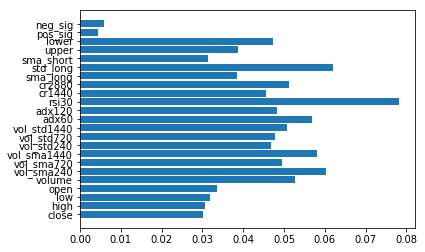

In [25]:
plt.barh(X_train.columns, fit_rfc.feature_importances_)

### Test the RF 

Check the performance of the trained RF on the signals generated on the test set. 

In [26]:
df3 = data.loc['2020-01-01':].copy()

In [27]:
cumRet, pmdd = mixed_strategy_noncont_meta(df3, 5400, 270, 1.75)
df3.index = pd.to_datetime(df3.index)

take profits: 6     stopped out: 26     time breaches: 67 
pos_ret: 31     neg_ret: 41 
eop_closes: 0     eop_prct_change 1     jump: 0 



In [28]:
rets = cumRet/cumRet.shift(1).fillna(1)-1
rets = rets[rets!=0]
rets = pd.Series(rets.to_numpy(),index=df3.signal[df3.signal!=0].index)

In [29]:
df3['returns'] = rets

In [30]:
df3['good_rets'] = np.where(df3.returns>=.01, 1, -1)

In [31]:
X_test = df3.loc[:, 'close':'signal'][df3.signal!=0]
Y_test = df3['good_rets'][df3.signal!=0]

In [32]:
X_test['pos_sig'] = 0
X_test['pos_sig'][X_test.signal==1] = 1
X_test['neg_sig'] = 0
X_test['neg_sig'][X_test.signal==-1] = 1
X_test = X_test.drop('signal', axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
yhat_rfc = fit_rfc.predict(X_test)
yprob_rfc = fit_rfc.predict_proba(X_test)[:,1]

In [34]:
np.mean(yhat_rfc != Y_test)

0.4166666666666667

In [35]:
fit_rfc.classes_

array([-1,  1])

In [36]:
# the RF model appears to be okay at predicting negative performances

np.mean(yhat_rfc[yprob_rfc<.5]==Y_test[yprob_rfc<.5])

0.7142857142857143

In [37]:
from sklearn.metrics import roc_curve

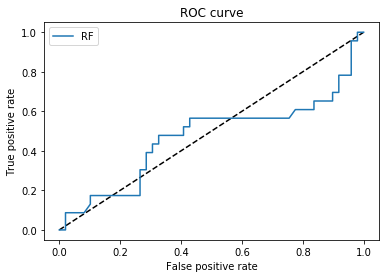

In [38]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, yprob_rfc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# the shape of the ROC doesn't look good though for this particular model

#### Run the strategy on the test set but incorporate the predictions from the trained RF model to help decide position size. 

Here, it does not look like the RF model helped much... However, with better features and volume bars (instead of minute bars), this methodology should yield decent results. 

As stated earlier, this notebook only seeks to provide the framework for using Meta Labelling to help generate better trading performance. Much optimization and improvement can be added in the future. 

In [39]:
df4 = data.loc['2020-01-01':].copy()

In [40]:
# run the strategy on the test set with the trained RF model 
# and position size for predicted poor signals at 80% of portfolio

cumRet, pmdd, cr_m, pmdd_m = mixed_strategy_noncont_meta(df4.copy(), 5400, 270, 1.75, ml_model=fit_rfc, ps=.8)
df4.index = pd.to_datetime(df4.index)

take profits: 6     stopped out: 26     time breaches: 67 
pos_ret: 31     neg_ret: 41 
eop_closes: 0     eop_prct_change 1     jump: 0 



In [41]:
# performance result without help from ML model

cumRet[-1]

1.12607532542052

In [42]:
# performance result WITH help from ML model
# not as good as without

cr_m[-1]

1.1037206257788257